# Importing the necessary libraries

In [1]:
import pandas as pd
from patsy import dmatrices, build_design_matrices
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Reading the data

In [2]:
amseterdam_airbnb = pd.read_csv('/Users/Kaushik Kumaran/Documents/GitHub/MISs381N-finalproject/listings.csv')
amseterdam_airbnb.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.36435,4.94358,Private room,60,3,278,2019-11-21,2.90,1,137
1,20168,Studio with private bathroom in the centre 1,59484,Alexander,NaN,Centrum-Oost,52.36407,4.89393,Private room,106,1,339,2020-03-27,3.73,2,0


# Pre processing and cleaning

In [3]:
amseterdam_airbnb['reviews_per_month'] = amseterdam_airbnb['reviews_per_month'].fillna(0)
amseterdam_airbnb.drop(['neighbourhood_group'], inplace=True, axis=1)

Q1 = amseterdam_airbnb['price'].quantile(0.25)
Q3 = amseterdam_airbnb['price'].quantile(0.75)
IQR = Q3 - Q1
amseterdam_airbnb = amseterdam_airbnb[~((amseterdam_airbnb['price'] < (Q1 - 1.5 * IQR)) |(amseterdam_airbnb['price'] > (Q3 + 1.5 * IQR)))]

# Scaling the variables

In [4]:
norm_col = ['latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

amseterdam_airbnb_norm = amseterdam_airbnb.copy()
for name in norm_col:
    amseterdam_airbnb_norm[name] = (amseterdam_airbnb_norm[name] - amseterdam_airbnb_norm[name].min())/(amseterdam_airbnb_norm[name].max() - amseterdam_airbnb_norm[name].min())

    
a = amseterdam_airbnb['price'].max()
b = amseterdam_airbnb['price'].min()

def de_norm(MSE) : 
    return (MSE*(a-b))+b

# Linear Regression

In [5]:
y,X = dmatrices('price ~ neighbourhood + room_type + number_of_reviews + availability_365 \
                + minimum_nights + reviews_per_month + calculated_host_listings_count',
                data = amseterdam_airbnb_norm, return_type = 'dataframe')

y = y['price'].values


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

lm = sm.OLS(y_train,X_train)
model = lm.fit() 
from sklearn import metrics

prediction_train = model.predict(X_train)
rms = mean_squared_error(de_norm(y_train), de_norm(prediction_train), squared=False)
print(rms)
print(model.summary())

51.51293296309212
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     121.6
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:51:59   Log-Likelihood:                 4059.4
No. Observations:               11089   AIC:                            -8059.
Df Residuals:                   11059   BIC:                            -7839.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [7]:
prediction_test = model.predict(X_test)
rms = mean_squared_error(de_norm(y_test), de_norm(prediction_test), squared=False)
rms

51.53877176676307

In [8]:
def cv_accuracy_score(X, y):
    """For each fold, fit the nearest neighbors model
    with nn nearest neighbors on the train, and return accuracy
    on the test."""
    
    MSE_array = []
    model = linear_model.LinearRegression()
    
    kfold = ShuffleSplit(n_splits=5, random_state=None).split(X, y)
    
    for train, holdout in kfold:
        # Select the training and testing data using the indices
        # provided by kfold
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Compute test accuracy
        MSE = mean_squared_error(de_norm(y_test), de_norm(prediction_test), squared=False)
        MSE_array.append(MSE)
    return average(MSE_array)

cv_accuracy_score(X,y)

51.53877176676307

# Lasso Regression

In [9]:
clf = linear_model.Lasso(alpha=0.1)
result = clf.fit(X_train, y_train) 
from sklearn import metrics

prediction_train = result.predict(X_train)
rms = mean_squared_error(de_norm(y_train), de_norm(prediction_train), squared=False)
rms

59.15650417087327

In [10]:
prediction_test = result.predict(X_test)
rms = mean_squared_error(de_norm(y_test), de_norm(prediction_test), squared=False)
rms

58.583601412435826

In [11]:
result.coef_

array([ 0., -0., -0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0.,  0.,  0., -0., -0., -0., -0.,
        0.,  0., -0., -0.])

In [12]:
def cv_accuracy_score(X, y,alpha):
    """For each fold, fit the nearest neighbors model
    with nn nearest neighbors on the train, and return accuracy
    on the test."""
    
    MSE_array = []
    model = linear_model.Lasso(alpha=alpha)
    
    kfold = ShuffleSplit(n_splits=5, random_state=None).split(X, y)
    
    for train, holdout in kfold:
        # Select the training and testing data using the indices
        # provided by kfold
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Compute test accuracy
        MSE = mean_squared_error(de_norm(model.predict(X_holdout)), de_norm(y_holdout), squared=False)
        MSE_array.append(MSE)
    return average(MSE_array)

cv_accuracy_score(X,y,0.1)

58.410501702649825

Text(0, 0.5, 'MSE in Price')

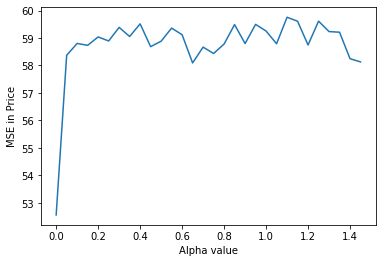

In [13]:
alpha = [(x*0.01) * 5 for x in range(30)]
scores = [cv_accuracy_score(X, y, num_nbrs) for num_nbrs in alpha]
plot(alpha, scores)
xlabel('Alpha value')
ylabel('MSE in Price')

In [14]:
min_score = min(scores)
for i in range(len(scores)):
    if scores[i] == min_score:
        index = i
        break
print("alpha value for minimum RMSE of ",round(scores[index],2)," is :",alpha[index])

alpha value for minimum RMSE of  52.56  is : 0.0


# Ridge Regression

In [15]:
clf = linear_model.Ridge(alpha=0.1)
result = clf.fit(X_train, y_train) 
from sklearn import metrics

prediction_train = result.predict(X_train)
rms = mean_squared_error(de_norm(y_train), de_norm(prediction_train), squared=False)
rms

51.512969518126766

In [16]:
prediction_test = result.predict(X_test)
rms = mean_squared_error(de_norm(y_test), de_norm(prediction_test), squared=False)
rms

51.5395086504574

In [17]:
X.columns, result.coef_

(Index(['Intercept', 'neighbourhood[T.Bijlmer-Oost]',
        'neighbourhood[T.Bos en Lommer]',
        'neighbourhood[T.Buitenveldert - Zuidas]',
        'neighbourhood[T.Centrum-Oost]', 'neighbourhood[T.Centrum-West]',
        'neighbourhood[T.De Aker - Nieuw Sloten]',
        'neighbourhood[T.De Baarsjes - Oud-West]',
        'neighbourhood[T.De Pijp - Rivierenbuurt]',
        'neighbourhood[T.Gaasperdam - Driemond]',
        'neighbourhood[T.Geuzenveld - Slotermeer]',
        'neighbourhood[T.IJburg - Zeeburgereiland]',
        'neighbourhood[T.Noord-Oost]', 'neighbourhood[T.Noord-West]',
        'neighbourhood[T.Oostelijk Havengebied - Indische Buurt]',
        'neighbourhood[T.Osdorp]', 'neighbourhood[T.Oud-Noord]',
        'neighbourhood[T.Oud-Oost]', 'neighbourhood[T.Slotervaart]',
        'neighbourhood[T.Watergraafsmeer]', 'neighbourhood[T.Westerpark]',
        'neighbourhood[T.Zuid]', 'room_type[T.Hotel room]',
        'room_type[T.Private room]', 'room_type[T.Shared room]',

On interpretation we see that:
- Higher the minimum nights, lesser the price
- The prices are very low for shared rooms
- Neighbourhood centrum west has higher prices

In [18]:
def cv_accuracy_score(X, y,alpha):
    """For each fold, fit the nearest neighbors model
    with nn nearest neighbors on the train, and return accuracy
    on the test."""
    
    MSE_array = []
    model = linear_model.Ridge(alpha=alpha)
    
    kfold = ShuffleSplit(n_splits=5, random_state=None).split(X, y)
    
    for train, holdout in kfold:
        # Select the training and testing data using the indices
        # provided by kfold
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Compute test accuracy
        MSE = mean_squared_error(de_norm(model.predict(X_holdout)), de_norm(y_holdout), squared=False)
        MSE_array.append(MSE)
    return average(MSE_array)

cv_accuracy_score(X,y,0.1)

50.87497381936445

Text(0, 0.5, 'MSE in Price')

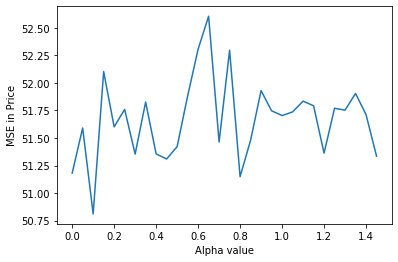

In [19]:
alpha = [(x*0.01) * 5 for x in range(30)]
scores = [cv_accuracy_score(X, y, num_nbrs) for num_nbrs in alpha]
plot(alpha, scores)
xlabel('Alpha value')
ylabel('MSE in Price')

In [20]:
min_score = min(scores)
for i in range(len(scores)):
    if scores[i] == min_score:
        index = i
        break
print("alpha value for minimum RMSE of ",round(scores[index],2)," is :",alpha[index])

alpha value for minimum RMSE of  50.81  is : 0.1


In [21]:
cv_accuracy_score(X,y,0.2)

51.534297017745075

In [22]:
# X_test['Y_test_value'] = de_norm(y_test)
# X_test['Y_pred_value'] = de_norm(prediction_test)

In [25]:
# X_test.to_csv('prices.csv',index = False)

# Ridge Regression after Splitting the data based on Room Type

In [26]:
norm_col = ['latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

amseterdam_airbnb_norm = amseterdam_airbnb.copy()
for name in norm_col:
    amseterdam_airbnb_norm[name] = (amseterdam_airbnb_norm[name] - amseterdam_airbnb_norm[name].min())/(amseterdam_airbnb_norm[name].max() - amseterdam_airbnb_norm[name].min())

    
a = amseterdam_airbnb['price'].max()
b = amseterdam_airbnb['price'].min()

def de_norm(MSE) : 
    return (MSE*(a-b))+b

In [33]:
amseterdam_airbnb_norm_entire_home = amseterdam_airbnb_norm[amseterdam_airbnb_norm['room_type']=='Entire home/apt']
amseterdam_airbnb_norm_pvt_room = amseterdam_airbnb_norm[amseterdam_airbnb_norm['room_type']=='Private room']

# Ridge Regression - Entire Home/apt

In [68]:
y,X = dmatrices('price ~ neighbourhood + number_of_reviews + availability_365 \
                + minimum_nights + reviews_per_month + calculated_host_listings_count',
                data = amseterdam_airbnb_norm_entire_home, return_type = 'dataframe')

y = y['price'].values

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = linear_model.Ridge(alpha=0.1)
result = clf.fit(X_train, y_train) 
from sklearn import metrics

prediction_train = result.predict(X_train)
rms = mean_squared_error(de_norm(y_train), de_norm(prediction_train), squared=False)
rms

53.68456262973259

In [70]:
prediction_test = result.predict(X_test)
rms = mean_squared_error(de_norm(y_test), de_norm(prediction_test), squared=False)
rms

54.029150916731744

In [71]:
X.columns, result.coef_

(Index(['Intercept', 'neighbourhood[T.Bijlmer-Oost]',
        'neighbourhood[T.Bos en Lommer]',
        'neighbourhood[T.Buitenveldert - Zuidas]',
        'neighbourhood[T.Centrum-Oost]', 'neighbourhood[T.Centrum-West]',
        'neighbourhood[T.De Aker - Nieuw Sloten]',
        'neighbourhood[T.De Baarsjes - Oud-West]',
        'neighbourhood[T.De Pijp - Rivierenbuurt]',
        'neighbourhood[T.Gaasperdam - Driemond]',
        'neighbourhood[T.Geuzenveld - Slotermeer]',
        'neighbourhood[T.IJburg - Zeeburgereiland]',
        'neighbourhood[T.Noord-Oost]', 'neighbourhood[T.Noord-West]',
        'neighbourhood[T.Oostelijk Havengebied - Indische Buurt]',
        'neighbourhood[T.Osdorp]', 'neighbourhood[T.Oud-Noord]',
        'neighbourhood[T.Oud-Oost]', 'neighbourhood[T.Slotervaart]',
        'neighbourhood[T.Watergraafsmeer]', 'neighbourhood[T.Westerpark]',
        'neighbourhood[T.Zuid]', 'number_of_reviews', 'availability_365',
        'minimum_nights', 'reviews_per_month',
   

In [72]:
def cv_accuracy_score(X, y,alpha):
    """For each fold, fit the nearest neighbors model
    with nn nearest neighbors on the train, and return accuracy
    on the test."""
    
    MSE_array = []
    model = linear_model.Ridge(alpha=alpha)
    
    kfold = ShuffleSplit(n_splits=5, random_state=None).split(X, y)
    
    for train, holdout in kfold:
        # Select the training and testing data using the indices
        # provided by kfold
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Compute test accuracy
        MSE = mean_squared_error(de_norm(model.predict(X_holdout)), de_norm(y_holdout), squared=False)
        MSE_array.append(MSE)
    return average(MSE_array)

cv_accuracy_score(X,y,0.1)

53.94937451178147

Text(0, 0.5, 'MSE in Price')

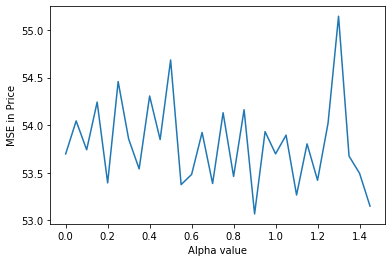

In [73]:
alpha = [(x*0.01) * 5 for x in range(30)]
scores = [cv_accuracy_score(X, y, num_nbrs) for num_nbrs in alpha]
plot(alpha, scores)
xlabel('Alpha value')
ylabel('MSE in Price')

In [74]:
min_score = min(scores)
for i in range(len(scores)):
    if scores[i] == min_score:
        index = i
        break
print("alpha value for minimum RMSE of ",round(scores[index],2)," is :",alpha[index])

alpha value for minimum RMSE of  53.07  is : 0.8999999999999999


In [58]:
cv_accuracy_score(X,y,1.25)

54.35424946133976

# Ridge Regression - Private Room

In [59]:
y,X = dmatrices('price ~ neighbourhood + number_of_reviews + availability_365 \
                + minimum_nights + reviews_per_month + calculated_host_listings_count',
                data = amseterdam_airbnb_norm_pvt_room, return_type = 'dataframe')

y = y['price'].values

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = linear_model.Ridge(alpha=0.1)
result = clf.fit(X_train, y_train) 
from sklearn import metrics

prediction_train = result.predict(X_train)
rms = mean_squared_error(de_norm(y_train), de_norm(prediction_train), squared=False)
rms

39.966549882603005

In [61]:
prediction_test = result.predict(X_test)
rms = mean_squared_error(de_norm(y_test), de_norm(prediction_test), squared=False)
rms

42.5559439504541

In [62]:
X.columns, result.coef_

(Index(['Intercept', 'neighbourhood[T.Bijlmer-Oost]',
        'neighbourhood[T.Bos en Lommer]',
        'neighbourhood[T.Buitenveldert - Zuidas]',
        'neighbourhood[T.Centrum-Oost]', 'neighbourhood[T.Centrum-West]',
        'neighbourhood[T.De Aker - Nieuw Sloten]',
        'neighbourhood[T.De Baarsjes - Oud-West]',
        'neighbourhood[T.De Pijp - Rivierenbuurt]',
        'neighbourhood[T.Gaasperdam - Driemond]',
        'neighbourhood[T.Geuzenveld - Slotermeer]',
        'neighbourhood[T.IJburg - Zeeburgereiland]',
        'neighbourhood[T.Noord-Oost]', 'neighbourhood[T.Noord-West]',
        'neighbourhood[T.Oostelijk Havengebied - Indische Buurt]',
        'neighbourhood[T.Osdorp]', 'neighbourhood[T.Oud-Noord]',
        'neighbourhood[T.Oud-Oost]', 'neighbourhood[T.Slotervaart]',
        'neighbourhood[T.Watergraafsmeer]', 'neighbourhood[T.Westerpark]',
        'neighbourhood[T.Zuid]', 'number_of_reviews', 'availability_365',
        'minimum_nights', 'reviews_per_month',
   

In [63]:
def cv_accuracy_score(X, y,alpha):
    """For each fold, fit the nearest neighbors model
    with nn nearest neighbors on the train, and return accuracy
    on the test."""
    
    MSE_array = []
    model = linear_model.Ridge(alpha=alpha)
    
    kfold = ShuffleSplit(n_splits=5, random_state=None).split(X, y)
    
    for train, holdout in kfold:
        # Select the training and testing data using the indices
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Compute test accuracy
        MSE = mean_squared_error(de_norm(model.predict(X_holdout)), de_norm(y_holdout), squared=False)
        MSE_array.append(MSE)
    return average(MSE_array)

cv_accuracy_score(X,y,0.1)

40.26819596048258

Text(0, 0.5, 'MSE in Price')

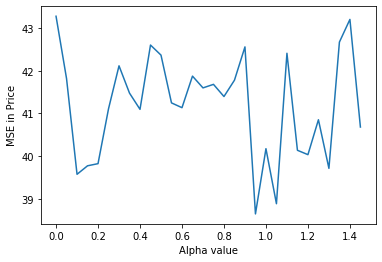

In [64]:
alpha = [(x*0.01) * 5 for x in range(30)]
scores = [cv_accuracy_score(X, y, num_nbrs) for num_nbrs in alpha]
plot(alpha, scores)
xlabel('Alpha value')
ylabel('MSE in Price')

In [65]:
min_score = min(scores)
for i in range(len(scores)):
    if scores[i] == min_score:
        index = i
        break
print("alpha value for minimum RMSE of ",round(scores[index],2)," is :",alpha[index])

alpha value for minimum RMSE of  38.64  is : 0.95


In [66]:
cv_accuracy_score(X,y,0.95)

40.74125803021608